In [24]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import chromatix.functional as cx
import jax.numpy as jnp
from jax import random
from chromatix.elements import VectorPlaneWave
import jax
import matplotlib.pyplot as plt
from skimage import io
from einops import rearrange
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Vector case

## Build empty plane wave field

In [25]:
spectrum = jnp.array(0.532)
spectral_density = 1
n = 1

field = cx.empty_field(
    shape=(512, 512), dx=1.0, spectrum=spectrum, spectral_density=spectral_density, polarized=True
)

print("field shape", field.shape)

#Add the input phase for polarization light
phi = 0 # angle between z axis and xy plane
theta = 0 # angle between x and y
k = n * 2 * jnp.pi / spectrum * jnp.array([jnp.sin(phi)* jnp.sin(theta), jnp.sin(phi) * jnp.cos(theta)]) # y and x 
Ep = jnp.array((0,0,1))  #z,y,x

source = VectorPlaneWave(shape=(512, 512), dx = 0.0001, n = 1, spectrum=spectrum, spectral_density=1.0, k = k, Ep = Ep)

params = source.init(random.PRNGKey(42))
field = source.apply(params)
# field = cx.vector_plane_wave(field, k, E0)
print(field.shape)

field shape (1, 3, 512, 512, 1)
(1, 3, 512, 512, 1)


## Propagate the field using Frenel transfer function

In [23]:
field = cx.transfer_propagate(field, z = 7, n = 1, N_pad = 0 )
I = jnp.sum(jnp.abs(field.u)**2, axis = -1)
print(field.shape)
print(I.squeeze().shape)

fx shape is: (1, 1, 512, 1, 1)
(1, 3, 512, 512, 1)
(3, 512, 512)


## Light transfer through a linear polarizer

In [5]:
field = cx.linear_polarizer(field, jnp.pi/2)
I = jnp.sum(jnp.abs(field.u)**2, axis = -1)
# field = cx.linear_polarizer(field, jnp.pi)

In [26]:
u = jnp.array((3,3,512,512,4,3))
field.replace(u = u)
print(field.u[:,1:3,:,:,:].shape)

(1, 2, 512, 512, 1)


In [27]:
print(I.squeeze().shape)
I3d = I.squeeze()
print(I3d[0,:,:])

(3, 512, 512)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Make thin samples using Jones Matrix

In [31]:
sample_delay = io.imread("Map_512.tiff")
print(sample_delay.shape)
absorption = jnp.ones((1,2,2,512,512,1))   #[1 2 2 H W 1]
phase = jnp.einsum("ijmn, mn -> ijmn", jnp.ones((2,2,512,512)), sample_delay/jnp.max(jnp.max(sample_delay)))   #[1 2 2 H W 1]
phase = rearrange(phase, "i j m n -> 1 i j m n 1")

Jsampe = cx.jones_sample(field, absorption, phase)

(512, 512)


[[[[[1.e-04]]]]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


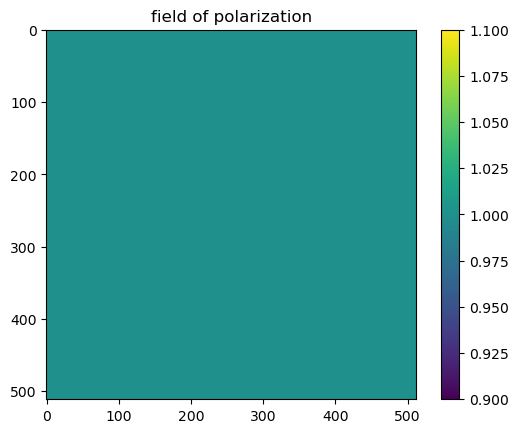

In [32]:
print(field.dx)
print(field.intensity.squeeze())
# plt.imshow(I.squeeze()[0,:,:])
plt.imshow(field.intensity.squeeze())
plt.title("field of polarization")
plt.colorbar()
plt.show()

# Scaler case

In [1]:
# We first create an empty field. 
N = 512
spectrum = jnp.array((0.2,0.532))
spectral_density = jnp.array((0.5,0.5))

field = cx.empty_field(shape=(N, N), dx=0.2, spectrum=spectrum, spectral_density=spectral_density)

# And then turn it into the field generated by the point source afterb the lens.
# field = cx.plane_wave(field, z=0.0, f=10.0, n=1.0, NA=0.8)
# print("field shape", field.shape)

#Add the input phase for polarization light
phi = 0.1 # angle between z axis and xy plane
theta = 1 # angle between x and y
n = 1
kykx = n * 2 * jnp.pi / spectrum * jnp.array([jnp.sin(phi)* jnp.sin(theta), jnp.sin(phi) * jnp.cos(theta)]) # y and x 

# source = PlaneWave(shape=(N, N), dx = 0.0001, spectrum=spectrum, spectral_density=1.0, power = 1, pupil = None, phase = jnp.ones([1,N,N,1]), k = k)

# params = source.init(random.PRNGKey(42))
# field = source.apply(params)
# # # field = cx.vector_plane_wave(field, k, E0)
# print(field.shape)
print(kykx)
field = cx.plane_wave(field, kykx = kykx)

NameError: name 'jnp' is not defined

In [40]:
field = cx.transfer_propagate(field, z = 7, n = 1, N_pad = 10 )

AttributeError: 'Array' object has no attribute 'spectrum'

? why padding different, simulated field is different
The padding means the propagation involves

[[[[[1.e-04]]]]]


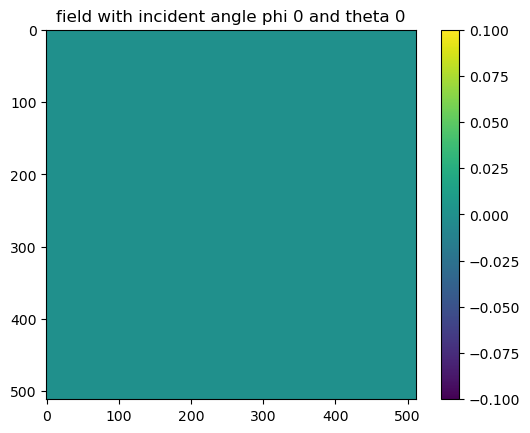

In [31]:
print(field.dx)
fig,ax = plt.subplots()
im = ax.imshow(field.intensity.squeeze())
ax.set_title(("field with incident angle phi "+ str(phi) + " and theta "  + str(theta)))
# xaxis = jnp.arange(-field.dx*N/2,field.dx*N/2,N)
# ax.set_xticks([-field.dx*N/2,0,field.dx*N/2])
# # ax.set_xlim([-N*field.dx,N*field.dx])
fig.colorbar(im, orientation='vertical')
plt.show()